# Exercise 4.9

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# parameters
max_capital = 100
ph = [0.25, 0.55]  # probability of the coin coming up heads
theta = 2e-11
gamma = 1
states = np.arange(1, max_capital)

In [3]:
def poss_a(state, max_capital): # All possible actions from a state
        return np.arange(1, np.minimum(state, max_capital - state) + 1)

In [4]:
def val_eval(state, value, action, p_h): # value evaluation
        return gamma * value[state + action] * p_h + gamma * value[state - action] * (1 - p_h) # value

In [5]:
def main_loop(p_h):
    
    sweeps = 0
    value = np.zeros(max_capital + 1)
    value[-1] = 1
    value_ls = []
    
    while True:
        delta = 0 
        for s in states:
            val = value[s]
            value[s] = np.max([val_eval(s, value, a, p_h) for a in poss_a(s, max_capital)])
            delta = np.maximum(delta, abs(val - value[s]))  # update delta
#         print('val:', val, ', value[s]', value[s])
#         print('delta:', delta, ', theta:', theta)
        if sweeps < 3:
            value_ls.append(value.copy())
        sweeps += 1
        if delta < theta:
            break
    print('Sweeps needed:', sweeps)
    value_ls.append(value.copy()) # final optimal value function
    policy = [poss_a(s, max_capital)[np.argmax([val_eval(s, value, a, p_h) for a in poss_a(s, max_capital)])] for s in states]
    return value_ls, policy, sweeps

When ph: 0.25
Sweeps needed: 17
When ph: 0.55
Sweeps needed: 1984


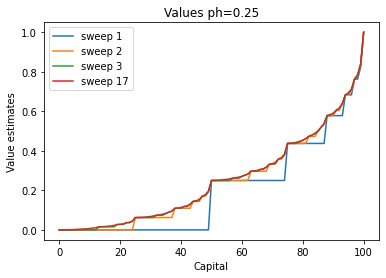

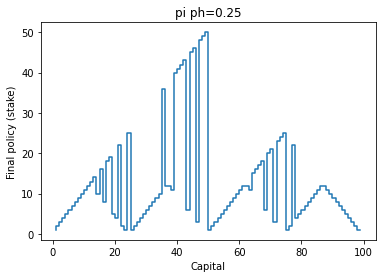

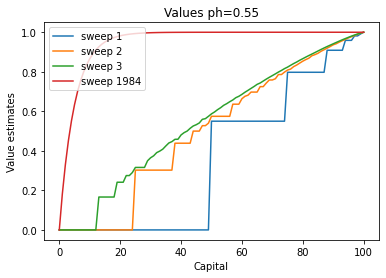

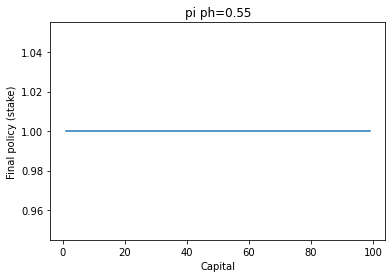

In [6]:
# main loop for different ph values
for p_h in ph:
    print('When ph:', p_h)

    value_ls, policy, sweeps = main_loop(p_h)

    # Value function results
    plt.figure()
    plt.plot(value_ls[0], label='sweep 1')
    plt.plot(value_ls[1], label='sweep 2')
    plt.plot(value_ls[2], label='sweep 3')
    plt.plot(value_ls[3], label='sweep {}'.format(sweeps))
    plt.legend(loc='upper left')
    plt.xlabel('Capital')
    plt.ylabel('Value estimates')
    plt.title('Values ph={}'.format(p_h))

    # Policy function results
    plt.figure()
    plt.step(states, policy)
    plt.xlabel('Capital')
    plt.ylabel('Final policy (stake)')
    plt.title('pi ph={}'.format(p_h))
        

# Exercise 5.12

In [7]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [8]:
def on_policy_mc_control(Q, C, pi):
    
    global gamma, EPISODES, EPSILON

    for episode in tqdm(range(EPISODES), position=0):

        if (episode % 10000)==0:
            EPSILON = max(0.1, EPSILON*.95)

        S, A, R = generate_episode(pi)
        T = len(S)

        appeared = dict()
                
        for t in range(T-1):
            Rt = R[t]
            St = S[t]
            At = A[t]

            if not (St,At) in appeared.keys():
                appeared[(St,At)] = True
            else:
                continue
           
            x_t = St[0]
            y_t = St[1]
            vx_t = St[2]
            vy_t = St[3]
    
            # compute return
            Gt = 0
            for i in range(t,T-1):
                Gt += (gamma**(i-t))*R[i]
            
            C[y_t, x_t, vx_t, vy_t,At] += 1
            Q[y_t, x_t, vx_t, vy_t,At] += 1/C[y_t, x_t, vx_t, vy_t,At]*(Gt - Q[y_t, x_t, vx_t, vy_t,At])

        for t in range(T):
            St = S[t]
            x_t = St[0]
            y_t = St[1]
            vx_t = St[2]
            vy_t = St[3]

            best_actions = np.where(Q[y_t,x_t,vx_t,vy_t,:]==np.max(Q[y_t,x_t,vx_t,vy_t,:]))[0]
            if len(best_actions)>1:
                best_action = np.random.choice(best_actions)
            else:
                best_action = best_actions[0]
            
            pi[y_t, x_t, vx_t, vy_t] = best_action

    return Q, pi

In [193]:
def off_policy_mc_control(Q, C, pi):
    global gamma, EPISODES

    
    for iter in tqdm(range(EPISODES), position=0):

        b = np.random.choice(np.arange(0,9), size=pi.shape)
        #     b = pi.copy()

        
        S, A, R = generate_episode(pi=b)
        G = 0
        W = 1
    
        T = len(S)
    
        for t in reversed(range(T)):
            Rt = R[t-1]
            St = S[t-1]
            At = A[t-1]
    
            x_t = St[0]
            y_t = St[1]
            vx_t = St[2]
            vy_t = St[3]
    
            G = gamma*G + Rt
            C[y_t,x_t,vx_t,vy_t,At] += W

            Q[y_t,x_t,vx_t,vy_t,At] += W/C[y_t,x_t,vx_t,vy_t,At] * (G - Q[y_t,x_t,vx_t,vy_t,At])

            max_action = np.max(Q[y_t,x_t,vx_t,vy_t,:])

            best_actions = np.where(Q[y_t,x_t,vx_t,vy_t,:] == max_action)[0]
            if len(best_actions)>1:
                best_action = np.random.choice(best_actions)
            else:
#                 best_action = best_actions[0]
                best_action = np.argmax(Q[y_t,x_t,vx_t,vy_t,:])
#             print(best_action)
            pi[y_t,x_t,vx_t,vy_t] = best_action

            if best_action != At:
#                 print('breaking!', T-t)
                break

#             dx, dy = action_to_pair(At)
            dx, dy = action_to_pair(b[y_t,x_t,vx_t,vy_t])

            if dx == 0: 
                pdx = 4/6
            elif dx == 1:
                pdx = 1/6
            else:
                pdx = 1/6
                
            if dy == 1:
                pdy = 4/6
            elif dy == 0:
                pdy = 1/6
            elif dy == -1:
                pdy = 1/6
            
            W *= 1/(pdx*pdy) 
#             W *= 1/b[y_t,x_t,vx_t,vy_t]
        
    return Q, pi


In [179]:
def generate_episode(pi=None, eps=None, noise=True):
    
    global track, actions, MAX_T, EPSILON

    H, W = track.shape
    
    if eps is None:
        eps = EPSILON

    # first state: random start location, 0 velocity
    x_0, y_0 = random_start()

    S = [(x_0, y_0, 0, 0)]  # x_t, y_t, vx_t, vy_t
    A = []
    R = []
    
    for t in range(MAX_T):
        
        St = S[-1]
        x_t = St[0]
        y_t = St[1]
        vx_t = St[2]
        vy_t = St[3]

        # Noise with probability 0.1 at each time step the velocity increments are both zero
        if noise and np.random.rand()<0.1:
            delta_vx = 0
            delta_vy = 0
            At1 = pair_to_action(delta_vx, delta_vy)
            
        elif pi is None:  
            delta_vx = np.random.choice([-1, 1, 1, 0, 0, 0]) # choose mostly no horiz accel (more zeros)
            delta_vy = np.random.choice([-1, 0, 1, 1, 1]) # choose mostly vert accel (more ones)
            At1 = pair_to_action(delta_vx, delta_vy)

        else:  # on-policy train
            At1 = pi[y_t,x_t,vx_t,vy_t] if np.random.rand()>eps else np.random.randint(9)
            delta_vx, delta_vy = action_to_pair(At1)
        
        # Both velocity components are restricted to be nonnegative and less than 5
        vx_t1 = max(0,min(MAX_SPEED, vx_t + delta_vx))
        vy_t1 = max(0,min(MAX_SPEED, vy_t + delta_vy))

        if vx_t1==0 and vy_t1==0:  # they cannot both be zero except at the starting line
            
            if np.random.rand()>0.5:
                vx_t1 = 1
            else:
                vy_t1 = 1
            At1 = pair_to_action(vx_t1, vy_t1) # should be 0,1 or 1,0
            assert (vx_t1+vy_t1)==1
                
        x_t1 = x_t + vx_t1
        y_t1 = y_t - vy_t1 # vertical is negative to go up in matrix

        # check if it went over boundary
        touched_boundary = False

        if x_t1 >= W or x_t1 < 0 or y_t1 >= H or y_t1 < 0 or track[y_t1, x_t1] == BOUNDARY:
            touched_boundary = True

        for vxx in range(vx_t1):
            
            if touched_boundary:
                 break
                    
            for vyy in range(vy_t1):
                
                if track[y_t - vyy,x_t+vxx] == BOUNDARY:
                    touched_boundary = True
                    break


        if touched_boundary:
            x_t1, y_t1 = random_start()
            vx_t1 = 0
            vy_t1 = 0

        St1 = (x_t1, y_t1, vx_t1, vy_t1)
        Rt1 = -1
        
        S.append(St1)
        A.append(At1)
        R.append(Rt1)

        if track[y_t1, x_t1] == FINISH:  # if the episode ended by reaching the finishing line
            break
            
    return S, A, R

In [180]:
def action_to_pair(a):
    
    assert(a>=0 and a<9)  # make sure the action is within the action space (i.e., 0 <= a < 9)
    
    if a == 0:
        vx, vy = 0, 0
    elif a == 1:
        vx, vy = 1, 0
    elif a == 2:
        vx, vy = 1, 1
    elif a == 3:
        vx, vy = 0, 1
    elif a == 4:
        vx, vy = -1, 0
    elif a == 5:
        vx, vy = -1, 1
    elif a == 6:
        vx, vy = -1, -1
    elif a == 7:
        vx, vy = 1, -1
    elif a == 8:
        vx, vy = 0, -1

    return vx, vy

In [171]:
def pair_to_action(vx, vy):
    
    assert np.abs(vx)<=1 and np.abs(vy)<=1  # accel should not be greater than 1
    
    if vx == 0 and vy == 0:
        a = 0
    elif vx == 1 and vy == 0:
        a = 1
    elif vx == 1 and vy == 1:
        a = 2
    elif vx == 0 and vy == 1:
        a = 3
    elif vx == -1 and vy == 0:
        a = 4
    elif vx == -1 and vy == 1:
        a = 5
    elif vx == -1 and vy == -1:
        a = 6
    elif vx == 1 and vy == -1:
        a = 7
    elif vx == 0 and vy == -1:
        a = 8

    return a

In [172]:
def random_start():
    
    global track

    # possible start positions
    Is, Js = np.where(track==START)
    ix_start = np.random.randint(len(Is))
    
    return  Js[ix_start], Is[ix_start] # horizontal coord first

In [173]:
def plot_sample(pi, it):
    
    global track

    H, W = track.shape

    S, A, R = generate_episode(pi, eps=0, noise=False)

    plt.clf()
    x_t = []
    y_t = []

    for St in S:
        x_t.append(St[0])
        y_t.append(St[1])

    plt.imshow(track, interpolation='none')
    plt.plot(np.asarray(x_t), np.asarray(y_t),'o-')
    plt.scatter(x_t[-1], y_t[-1], color='red', s=50)
    plt.title('Iteration ' + str(it))

# On-policy Track 1

In [158]:
# MAIN LOOP

START = 2
FINISH = 3
TRACK = 1
BOUNDARY = 0

gamma = 0.9

MAX_SPEED = 4
MAX_T = 500 # Max episode length
EPISODES = int(1e4)
EPSILON = 0.5

track = np.genfromtxt('racetrack.txt', delimiter=1)

actions = range(3*3) # cartesian product of (-1, 0, 1)

H, W = track.shape

Q = np.ones((H,W,MAX_SPEED+1,MAX_SPEED+1,9))*(-1*MAX_T)
C = np.zeros((H,W,MAX_SPEED+1,MAX_SPEED+1,9))

pi = np.random.randint(low=0, high=9, size=(H,W,MAX_SPEED+1,MAX_SPEED+1))

Q, pi = on_policy_mc_control(Q,C,pi)
# Q, pi = off_policy_mc_control(Q,C,pi)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 286.68it/s]


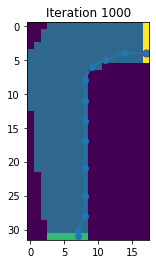

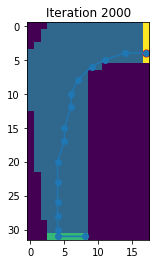

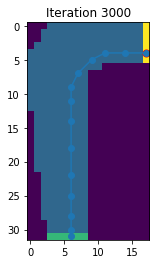

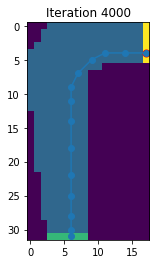

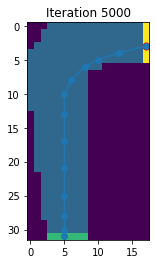

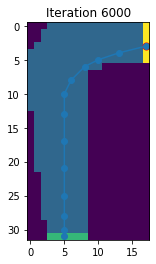

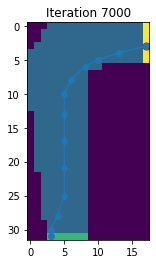

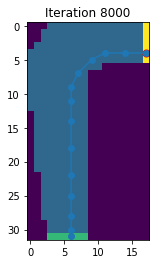

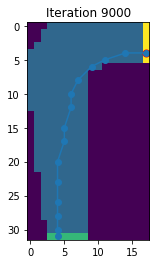

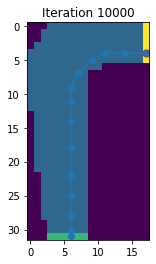

In [159]:
# Visualize

# plot a few more samples episodes
for i in range(10):
    plt.figure()
#     plot_sample(pi, EPISODES+i)
    plot_sample(pi, (i+1)*EPISODES // 10)

# On-policy Track 2

In [160]:
# MAIN LOOP

START = 2
FINISH = 3
TRACK = 1
BOUNDARY = 0

gamma = 0.9

MAX_SPEED = 4
MAX_T = 500 # Max episode length
EPISODES = int(1e4)
EPSILON = 0.5

track = np.genfromtxt('racetrack_2.txt', delimiter=1)

actions = range(3*3) # cartesian product of (-1, 0, 1)

H, W = track.shape

Q = np.ones((H,W,MAX_SPEED+1,MAX_SPEED+1,9))*(-1*MAX_T)
C = np.zeros((H,W,MAX_SPEED+1,MAX_SPEED+1,9))

pi = np.random.randint(low=0, high=9, size=(H,W,MAX_SPEED+1,MAX_SPEED+1))

Q, pi = on_policy_mc_control(Q,C,pi)
# Q, pi = off_policy_mc_control(Q,C,pi)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 503.77it/s]


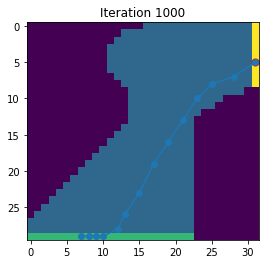

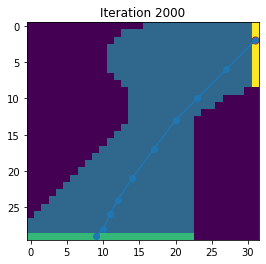

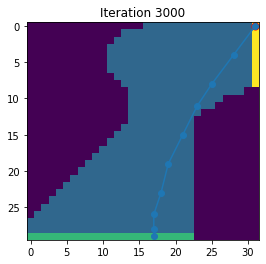

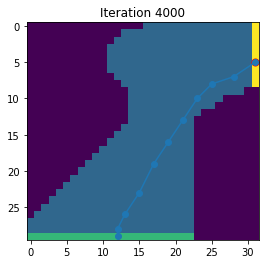

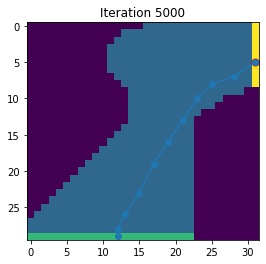

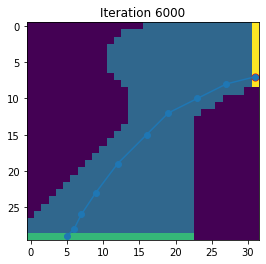

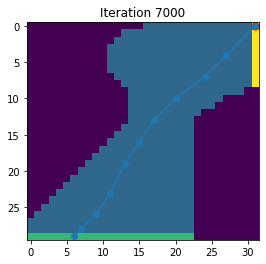

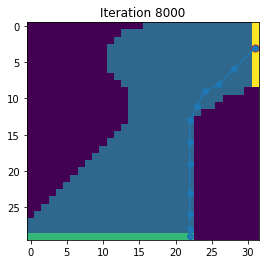

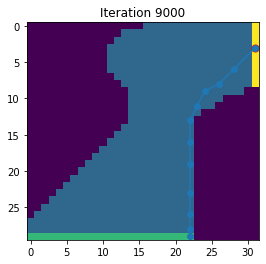

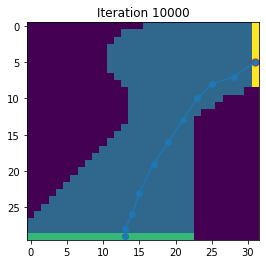

In [161]:
# Visualize

# plot a few more samples episodes
for i in range(10):
    plt.figure()
#     plot_sample(pi, EPISODES+i)
    plot_sample(pi, (i+1)*EPISODES // 10)

# Off-policy Track 1

In [189]:
# MAIN LOOP

START = 2
FINISH = 3
TRACK = 1
BOUNDARY = 0

gamma = 0.9

MAX_SPEED = 4
MAX_T = 500 # Max episode length
EPISODES = int(1e4)
EPSILON = 0.5

track = np.genfromtxt('racetrack.txt', delimiter=1)

actions = range(3*3) # cartesian product of (-1, 0, 1)

H, W = track.shape

Q = np.ones((H,W,MAX_SPEED+1,MAX_SPEED+1,9))*(-1*MAX_T)
C = np.zeros((H,W,MAX_SPEED+1,MAX_SPEED+1,9))

pi = np.random.randint(low=0, high=9, size=(H,W,MAX_SPEED+1,MAX_SPEED+1))

# Q, pi = on_policy_mc_control(Q,C,pi)
Q, pi = off_policy_mc_control(Q,C,pi)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:38<00:00, 258.34it/s]


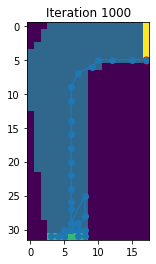

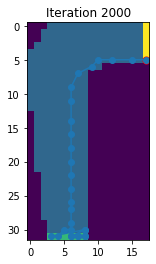

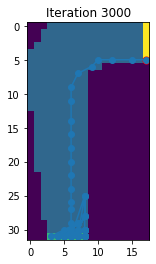

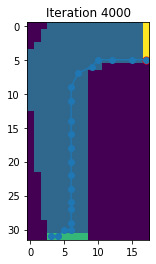

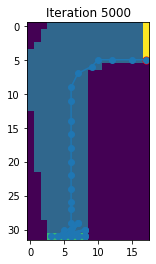

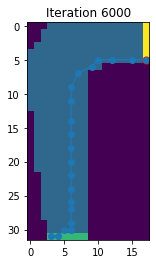

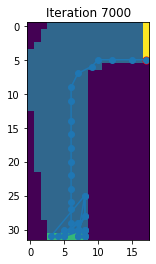

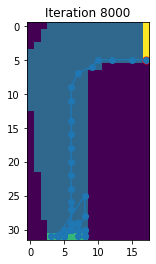

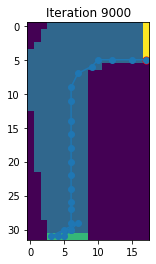

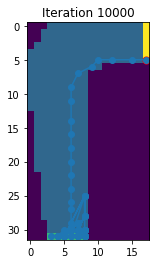

In [190]:
# Visualize

# plot a few more samples episodes
for i in range(10):
    plt.figure()
#     plot_sample(pi, EPISODES+i)
    plot_sample(pi, (i+1)*EPISODES // 10)

# Off-policy Track 2

In [194]:
# MAIN LOOP

START = 2
FINISH = 3
TRACK = 1
BOUNDARY = 0

gamma = 0.9

MAX_SPEED = 4
MAX_T = 500 # Max episode length
EPISODES = int(1e4)
EPSILON = 0.5

track = np.genfromtxt('racetrack_2.txt', delimiter=1)

actions = range(3*3) # cartesian product of (-1, 0, 1)

H, W = track.shape

Q = np.ones((H,W,MAX_SPEED+1,MAX_SPEED+1,9))*(-1*MAX_T)
C = np.zeros((H,W,MAX_SPEED+1,MAX_SPEED+1,9))

pi = np.random.randint(low=0, high=9, size=(H,W,MAX_SPEED+1,MAX_SPEED+1))

# Q, pi = on_policy_mc_control(Q,C,pi)
Q, pi = off_policy_mc_control(Q,C,pi)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 309.25it/s]


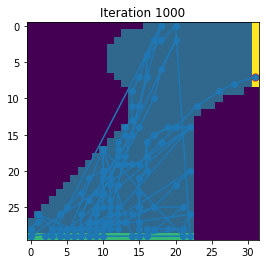

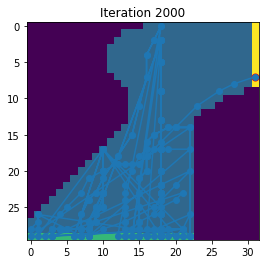

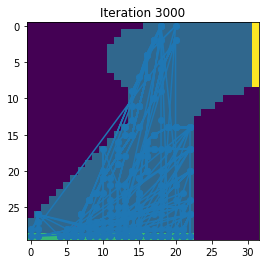

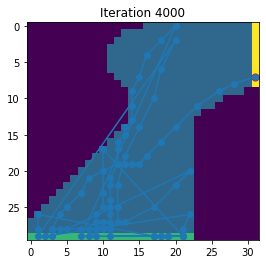

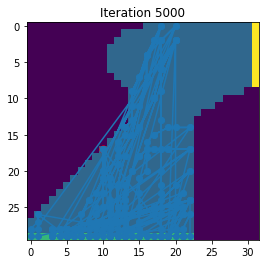

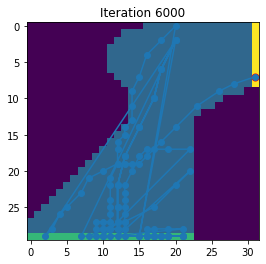

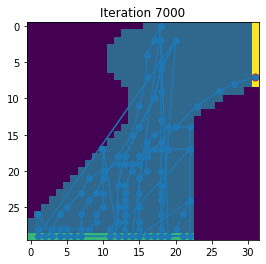

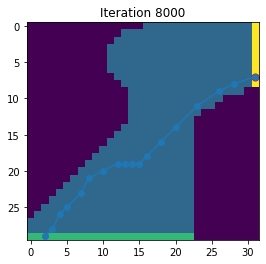

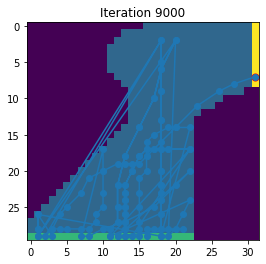

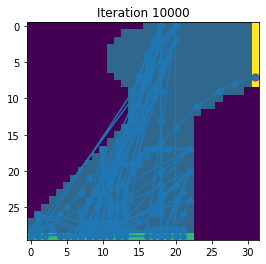

In [195]:
# Visualize

# plot a few more samples episodes
for i in range(10):
    plt.figure()
#     plot_sample(pi, EPISODES+i)
    plot_sample(pi, (i+1)*EPISODES // 10)